   Unnamed: 0  SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines  age  \
0           1                 1                              0.766127   45   
1           2                 0                              0.957151   40   
2           3                 0                              0.658180   38   
3           4                 0                              0.233810   30   
4           5                 0                              0.907239   49   

   NumberOfTime30-59DaysPastDueNotWorse  DebtRatio  MonthlyIncome  \
0                                     2   0.802982         9120.0   
1                                     0   0.121876         2600.0   
2                                     1   0.085113         3042.0   
3                                     0   0.036050         3300.0   
4                                     1   0.024926        63588.0   

   NumberOfOpenCreditLinesAndLoans  NumberOfTimes90DaysLate  \
0                               13                   

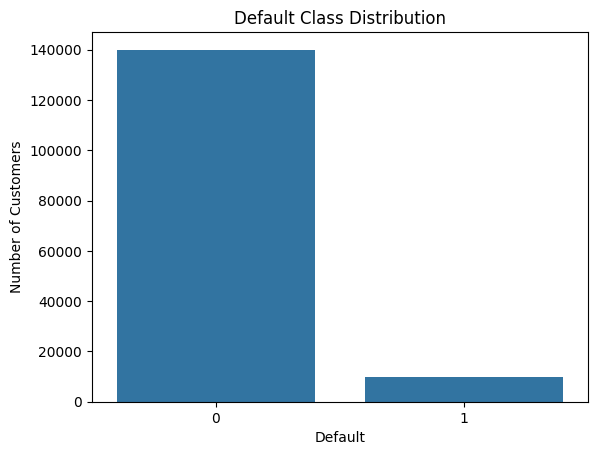

Balanced Training Set Class Distribution:
 Default
0    111979
1    111979
Name: count, dtype: int64


In [ ]:
#importing essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# sklearn bits
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler

# for balancing the classes
from imblearn.over_sampling import SMOTE

# model explainability
import shap

# for saving stuff
import joblib


# Load the dataset
df = pd.read_csv('cs-training.csv')

#printing head and info
print(df.head())
print(df.info())


#  Clean things up
# Strip spaces in column names
df.columns = df.columns.str.strip()
df = df.rename(columns={'SeriousDlqin2yrs': 'Default'})
#confirms that rename works
print("Columns after rename:")
print(df.columns)

print( df['Default'].value_counts())

# Handle missing values just using median for now, might revisit later
df.fillna(df.median(), inplace=True)


#  Quick EDA

# Visualizing class imbalance
sns.countplot(x='Default', data=df)
plt.title('Default Class Distribution')
plt.xlabel('Default')
plt.ylabel('Number of Customers')
plt.show()

# Split features & labels

# Drop target and that unnamed column
X = df.drop(['Default', 'Unnamed: 0'], axis=1)
y = df['Default']


#Train/Test Split

# Going with stratified split to maintain class proportions
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

#  Balance data using SMOTE

# This is synthetic oversampling

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print("Balanced Training Set Class Distribution:\n", y_train_res.value_counts())


#  Scale the feature
# Using StandardScaler — nothing fancy
scaler = StandardScaler()
X_train_res_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)


#  Train the model

# Random forest is a good baseline
clf = RandomForestClassifier(
    n_estimators=200,
    class_weight='balanced',  # helps with the imbalance
    random_state=42
)
clf.fit(X_train_res_scaled, y_train_res)


#  Evaluate

# Let’s see how it performs on test data
y_pred = clf.predict(X_test_scaled)

print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, clf.predict_proba(X_test_scaled)[:, 1]))


#  Explainability with SHAP

# TreeExplainer works nicely with random forests
explainer = shap.TreeExplainer(clf)
shap_vals = explainer.shap_values(X_test_scaled)

# Binary classification
# Note: In multiclass, SHAP gives a list. So, checking just in case
if isinstance(shap_vals, list):
    shap_values_to_plot = shap_vals[1]
else:
    shap_values_to_plot = shap_vals
#Also, shap expected value can be a list — same deal
expected_val = explainer.expected_value
if isinstance(expected_val, list):
    expected_val_to_use = expected_val[1]
else:
    expected_val_to_use = expected_val

# Plot a summary — I like the bar chart
shap.summary_plot(shap_values_to_plot, X_test, plot_type='bar')

# Init JavaScript stuff for force plot (it’s interactive)
shap.initjs()

# Force plot for the first test instance — more useful in notebook environments
shap.force_plot(expected_val_to_use, shap_values_to_plot[0, :], X_test.iloc[0, :])

#  Save the model & scaler

# Saving these to use later on unseen data — pretty standard
joblib.dump(clf, 'loan_default_model.pkl')
joblib.dump(scaler, 'scaler.pkl')